In [2]:
# import packages 
import cv2
import numpy as np
import os
import datetime as dt
import time
import pandas as pd

# define your own folder paths and names
data_folder = os.path.join(os.getcwd(),'data')
pv_data_folder = os.path.join(data_folder,'pv_data','pv_output_valid.pkl')

#image_folder = os.path.join(project_path,'freqsnapshot_high')
image_folder = os.path.join(data_folder,'raw_image_data')
image_name_format = '%Y%m%d%H%M%S'

output_folder =  os.path.join(data_folder,'data_expanded')
pred_folder = os.path.join(data_folder,'data_nowcast')

# operating parameter
output_img_shape = [224, 224, 3] # down-size the high-res image to this resolution
start_date = dt.datetime(2017,1,1) #NOTE: Inclusive of start date
end_date = dt.datetime(2020,1,1) #NOTE: Exclusive of end date (only end up with 2017-2019 data)


In [3]:
# Setting up test set
sunny_day = [(2017,9,15),(2017,10,6),(2017,10,22),(2018,2,16),(2018,6,12),(2018,6,23),(2019,1,25),(2019,6,23),(2019,7,14),(2019,10,14)]
cloudy_day = [(2017,6,24),(2017,9,20),(2017,10,11),(2018,1,25),(2018,3,9),(2018,10,4),(2019,5,27),(2019,6,28),(2019,8,10),(2019,10,19)]
sunny_datetime = [dt.datetime(day[0],day[1],day[2]) for day in sunny_day]
cloudy_datetime = [dt.datetime(day[0],day[1],day[2]) for day in cloudy_day]
test_dates = sunny_datetime + cloudy_datetime

In [4]:
test_dates

[datetime.datetime(2017, 9, 15, 0, 0),
 datetime.datetime(2017, 10, 6, 0, 0),
 datetime.datetime(2017, 10, 22, 0, 0),
 datetime.datetime(2018, 2, 16, 0, 0),
 datetime.datetime(2018, 6, 12, 0, 0),
 datetime.datetime(2018, 6, 23, 0, 0),
 datetime.datetime(2019, 1, 25, 0, 0),
 datetime.datetime(2019, 6, 23, 0, 0),
 datetime.datetime(2019, 7, 14, 0, 0),
 datetime.datetime(2019, 10, 14, 0, 0),
 datetime.datetime(2017, 6, 24, 0, 0),
 datetime.datetime(2017, 9, 20, 0, 0),
 datetime.datetime(2017, 10, 11, 0, 0),
 datetime.datetime(2018, 1, 25, 0, 0),
 datetime.datetime(2018, 3, 9, 0, 0),
 datetime.datetime(2018, 10, 4, 0, 0),
 datetime.datetime(2019, 5, 27, 0, 0),
 datetime.datetime(2019, 6, 28, 0, 0),
 datetime.datetime(2019, 8, 10, 0, 0),
 datetime.datetime(2019, 10, 19, 0, 0)]

In [5]:
def find_idx_with_dates(all_times,test_dates):
    idx=[]
    for test_day in test_dates:
        test_day_end = test_day + dt.timedelta(days = 1)
        idx+=np.nonzero((all_times>test_day)*(all_times<test_day_end))[0].tolist()
    return idx

# This two function does the same thing. Just that one is for np, the other for pd.
def find_time_within_nparray(time_array,time_point):
    probable_idx = np.searchsorted(time_array,time_point)
    
    # If the time point is after all the time in pv_data
    if probable_idx == len(time_array):
        return None   
    
    # See if the time point is actually a match 
    if time_array[probable_idx]== time_point: 
        return probable_idx
        
    else:
        return None

def find_time_within_pdseries(time_array,time_point):
    probable_idx = np.searchsorted(time_array,time_point)
    
    # If the time point is after all the time in pv_data
    if probable_idx == len(time_array):
        return None   
    
    # See if the time point is actually a match 
    if time_array[probable_idx]== time_point: 
        return probable_idx
        
    else:
        return None

def listdir_noini(path):
    f_list = []
    for f in os.listdir(path):
        _, file_extension = os.path.splitext(f)
        if not file_extension == '.ini':
            f_list.append(f)    
    
    return sorted(f_list)
    
# return a list list all the .jpg files in 
def listdir_jpg(path):
    f_list = []
    for f in os.listdir(path):
        _, file_extension = os.path.splitext(f)
        if file_extension == '.jpg':
            f_list.append(f)
            
    return sorted(f_list)

### Read in PV output 

In [ ]:
# Read in the pv output file
pv_output_all = pd.read_pickle(os.path.join(pv_data_folder))

# Obtain relevant data
pv_output_all = pv_output_all.loc[start_date:end_date]

### Read in image paths

In [ ]:
# Initialization: find all image file path
image_paths = []
all_times = []

years_list = listdir_noini(os.path.join(image_folder))
for year in years_list: # cycle through the years
    months_list = listdir_noini(os.path.join(image_folder,year))
    for month in months_list: # cycle through the months
        second_folder = os.listdir(os.path.join(image_folder,year,month))[0]
        dates_list  = listdir_noini(os.path.join(image_folder,year,month,second_folder))
        for date in dates_list: # cycle through each day
            image_filenames = listdir_jpg(os.path.join(image_folder,year,month,second_folder,date))
            #print(os.listdir(os.path.join(image_folder,year,month,second_folder,date)))
            for filename in image_filenames:
                image_paths.append(os.path.join(image_folder,year,month,second_folder,date,filename))
	
                all_times.append(dt.datetime.strptime(filename,image_name_format+'.jpg'))
            

# Only keep the one in the given time frame
image_paths = np.array(image_paths)
all_times = np.array(all_times)
print(all_times.shape)
in_range = (all_times>=start_date) & (all_times<end_date)
image_paths = image_paths[in_range]
all_times = all_times[in_range]

### Load in each image, and save ones with valid PV_output

In [ ]:
# Save images from snapshot folder to an npy file
# Designed for the high frequency (10s) dataset
number_images = len(image_paths)

all_images = np.ndarray([number_images] + output_img_shape,dtype='uint8')
pv_outputs = np.zeros(number_images)
validity_mask = np.zeros(number_images,dtype = bool)

# time counter
tic = time.process_time()

# Step through every snapshot, find if they have valid corresponding PV data

for i,image_path in enumerate(image_paths): # cycle through each file of the day
    # parse timestamp from image name
    curr_time = all_times[i]
    
    # test if there is corresponding data in PV data
    pv_idx = find_time_within_pdseries(pv_output_all.index,curr_time)
    if pv_idx is None:# if prediction ground truth not found
        print(curr_time,'has no PV record')
    else: 
        validity_mask[i] = 1
        frame = cv2.imread(os.path.join(image_path))
        # resizing the image to output_img_shape
        resizing_ratio = output_img_shape[0] / frame.shape[0]
        all_images[i] = cv2.resize(frame, None, fx=resizing_ratio, fy=resizing_ratio)
        pv_outputs[i] = pv_output_all.iloc[pv_idx]
    
    # prompt progress
    if i%100 == 0:
        print('processed {0} images/{1} images'.format(i,image_paths.size))
        if i%1000 == 0 and i>0:
            print('Expected finishing time:', dt.datetime.now()+
                  dt.timedelta(seconds = (time.process_time() - tic)*(image_paths.size/i-1)))
                                      
        
print('time_elapsed',time.process_time()-tic)

In [ ]:
# Cropping relevant information
all_times = all_times[validity_mask]
all_images = all_images[validity_mask]
pv_outputs = pv_outputs[validity_mask]

In [ ]:
print(len(all_times))

In [ ]:
#storing information
np.save(os.path.join(output_folder,'all_times_highfreq.npy'),all_times)
np.save(os.path.join(output_folder,'all_images_highfreq.npy'), all_images)
np.save(os.path.join(output_folder,'pv_outputs_highfreq.npy'), pv_outputs)

In [14]:
all_times.shape

(363375,)

In [15]:
all_images.shape

(363375, 224, 224, 3)

### Filter out repeating images

In [ ]:
# Load back in the previously processed times, images, and PV_outputs
all_times = np.load(os.path.join(output_folder,'all_times_highfreq.npy'), allow_pickle = True)
all_images = np.load(os.path.join(output_folder,'all_images_highfreq.npy'), allow_pickle = True)
pv_outputs = np.load(os.path.join(output_folder,'pv_outputs_highfreq.npy'), allow_pickle = True)

In [ ]:
batch_size = 50000
is_repeating_mask = np.empty(0, dtype=bool)

for i in range(0, len(all_images), batch_size):

	# Filter for repeating images (the OpenCV video capture function would sometimes fail to seek the correct frame 
	# and instead erroneously repeat the current frame)
	current_batch_size =  min(batch_size, len(all_images)-i)
	all_images_16 = all_images[i : i+batch_size ].astype('int16')

	# Calculated the change within two continuous image
	all_images_diff = all_images_16[1:] - all_images_16[:-1]
	all_images_diff_sum = np.sum(np.abs(all_images_diff), axis = (1,2,3))

	# create mask that record repeating status
	is_repeating_mask_batch = np.zeros(current_batch_size,dtype = bool)
	is_repeating_mask_batch[1:] = (all_images_diff_sum == 0)

	is_repeating_mask = np.concatenate([is_repeating_mask, is_repeating_mask_batch])

# Cropping relevant information
all_times = all_times[~is_repeating_mask]
all_images = all_images[~is_repeating_mask]
pv_outputs = pv_outputs[~is_repeating_mask]

In [66]:
all_times.shape

(363375,)

In [67]:
#storing information
np.save(os.path.join(output_folder,'all_times_highfreq.npy'),all_times)
np.save(os.path.join(output_folder,'all_images_highfreq.npy'), all_images)
np.save(os.path.join(output_folder,'pv_outputs_highfreq.npy'), pv_outputs)

In [6]:
# Load back in the previously processed times, images, and PV_outputs
all_times = np.load(os.path.join(output_folder,'all_times_highfreq.npy'), allow_pickle = True)
all_images = np.load(os.path.join(output_folder,'all_images_highfreq.npy'), allow_pickle = True)
pv_outputs = np.load(os.path.join(output_folder,'pv_outputs_highfreq.npy'), allow_pickle = True)

In [7]:
def store_trainval_test(all_times,image_log,pv_log,pred_folder):
    
    ## Splitting into Trainval and Test set 
    idx_test = find_idx_with_dates(all_times,test_dates)
    image_log_test = image_log[idx_test]
    pv_log_test = pv_log[idx_test]
    times_test = all_times[idx_test]

    # the rest become the trainval set
    mask_trainval = np.ones_like(pv_log,dtype = bool)
    mask_trainval[idx_test] = 0
    image_log_trainval = image_log[mask_trainval]
    pv_log_trainval = pv_log[mask_trainval]
    times_trainval = all_times[mask_trainval]
    
    print("times_trainval.shape",times_trainval.shape)
    print("image_log_trainval.shape",image_log_trainval.shape)
    print("pv_log_trainval.shape",pv_log_trainval.shape)
    
    print("times_test.shape",times_test.shape)
    print("image_log_test.shape",image_log_test.shape)
    print("pv_log_test.shape",pv_log_test.shape)
    
    #storing information
    # storing the training set
    np.save(os.path.join(pred_folder,'image_log_trainval.npy'), image_log_trainval)
    np.save(os.path.join(pred_folder,'pv_log_trainval.npy'), pv_log_trainval)
    np.save(os.path.join(pred_folder,'times_trainval.npy'),times_trainval)

    # storing the testing set
    np.save(os.path.join(pred_folder,'image_log_test.npy'), image_log_test)
    np.save(os.path.join(pred_folder,'pv_log_test.npy'), pv_log_test)
    np.save(os.path.join(pred_folder,'times_test.npy'),times_test)

In [11]:
store_trainval_test(all_times,all_images,pv_outputs,pred_folder)

times_trainval.shape (349372,)
image_log_trainval.shape (349372, 224, 224, 3)
pv_log_trainval.shape (349372,)
times_test.shape (14003,)
image_log_test.shape (14003, 224, 224, 3)
pv_log_test.shape (14003,)


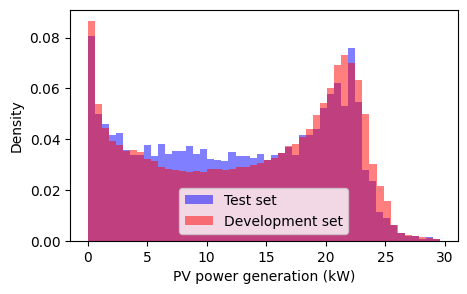

In [12]:
## Check the pv distribution
import matplotlib.pyplot as plt

pv_log_test = np.load(os.path.join(pred_folder,'pv_log_test.npy'))
pv_log_trainval = np.load(os.path.join(pred_folder,'pv_log_trainval.npy'))



plt.figure(figsize=(5,3))
plt.hist(pv_log_test, histtype='stepfilled', color='blue', density=True, bins=50, alpha=0.5,label='Test set')
plt.hist(pv_log_trainval, histtype='stepfilled', color='red', density=True, bins=50, alpha=0.5,label='Development set')
plt.ylabel('Density')
plt.xlabel('PV power generation (kW)')
plt.legend()
plt.savefig('pv_nowcast_density.pdf',bbox_inches='tight')

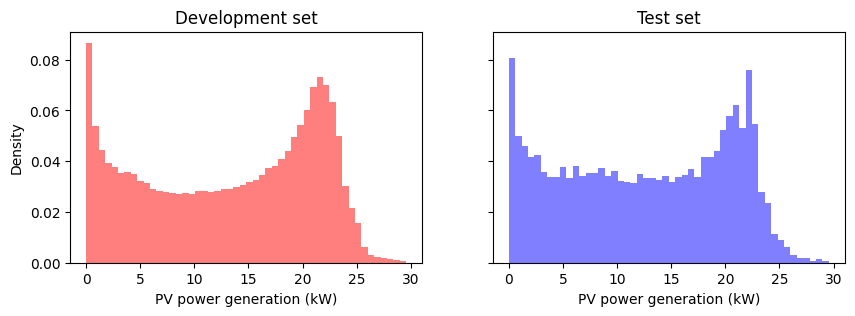

In [13]:
f,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10,3))
ax[0].hist(pv_log_trainval, histtype='stepfilled', color='red', density=True, bins=50, alpha=0.5,label='Development set')
ax[0].set_title('Development set')
ax[1].hist(pv_log_test, histtype='stepfilled', color='blue', density=True, bins=50, alpha=0.5,label='Test set')
ax[1].set_title('Test set')
ax[0].set_ylabel('Density')
ax[0].set_xlabel('PV power generation (kW)')
ax[1].set_xlabel('PV power generation (kW)')
#ax[0].legend()
plt.savefig('pv_nowcast_density_sep.pdf',bbox_inches='tight')